# ACCESS-OM2 1$^\circ$

This notebook documents our first attempt to run and analyse output from the ACCESS-OM2 Pre-release, implemented at 1°.


## Current Status


|** Run Name** | **Forcing** | ** Run ** | ** Status **|
|--------------|---------|-------------------------------------------------|-------------|
|1deg_jra55_ryf_spinup1 | JRA55 RYF9091| A short 10 year spinup with first pre-release code. Had bugs in runoff and salt fluxes.| Aborted after 10 years.| 
|1deg_jra55_ryf_spinup2 | JRA55 RYF9091| Second attempt at 1° test. There are significant problems with salt and mass conservation in this run.| Stopped at 100 years.| 
|1deg_jra55_ryf_spinup3 | JRA55 RYF9091| Nic's initial 1° test. Still problems with salinity. Also, much of this run has problems with the ocean.nc files. | Stopped at 80 years.| 
|1deg_jra55_ryf_spinup4 | JRA55 RYF9091| Nic's improved 1° test. This simulation seems to have fixed the salt and volume imbalance, but is missing some diagnostics.| Up to 25 years.| 
|1deg_jra55_ryf_spinup5 | JRA55 RYF9091| Andy's 1° test. Unfortunately, this run reverted to the old ice_salt_concentration = 0.004 namelist setting, so melt and salt are unbalanced. | Stopped at year 40.| 
|1deg_jra55_ryf_spinup6 | JRA55 RYF9091| Andy's New & Improved 1° test. Again, this has a salt imbalance | Stopped after 24 years.| 
|1deg_jra55_ryf_spinup7 | JRA55 RYF9091| Same as spinup6, but with the Red Sea fix switched off. | 6 years.| 

### Notes


**Last updated 30 August 2017**

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [7]:
cc.build_index()

Searching /g/data3/hh5/tmp/cosima/
Searching /g/data1/v45/APE-MOM
Found 49086 .nc files
Using database sqlite:////g/data1/v45/cosima-cookbook/cosima-cookbook.db
Files already indexed: 44902
Files found but not yet indexed: 4184
Indexing new .nc files...
[########################################] | 100% Completed |  1.6s
Found 5931 new variables
Saving results in database...
Indexing complete.


True

## Experiments

In [9]:
configuration = 'access-om2'
expts = cc.get_experiments(configuration)

configuration = 'mom-sis'
expts.extend(cc.get_experiments(configuration))
display(expts)

# This subset of cases are the important ones
esub = expts.copy()
esub.pop(4)
esub.pop(2)
esub.pop(1)
display(esub)

['1deg_jra55_ryf_spinup2',
 '1deg_jra55_ryf_spinup4',
 '1deg_jra55_ryf_spinup3',
 '1deg_jra55_ryf_spinup5',
 '1deg_jra55_ryf_spinup1',
 '1deg_jra55_ryf_spinup6',
 '1deg_jra55_ryf_spinup7',
 'mom-sis_core-nyf',
 'mom-sis_jra-ryf']

['1deg_jra55_ryf_spinup2',
 '1deg_jra55_ryf_spinup5',
 '1deg_jra55_ryf_spinup6',
 '1deg_jra55_ryf_spinup7',
 'mom-sis_core-nyf',
 'mom-sis_jra-ryf']

## Wind Stress
Just a simple plot showing zonally averaged zonal wind stress from each case.

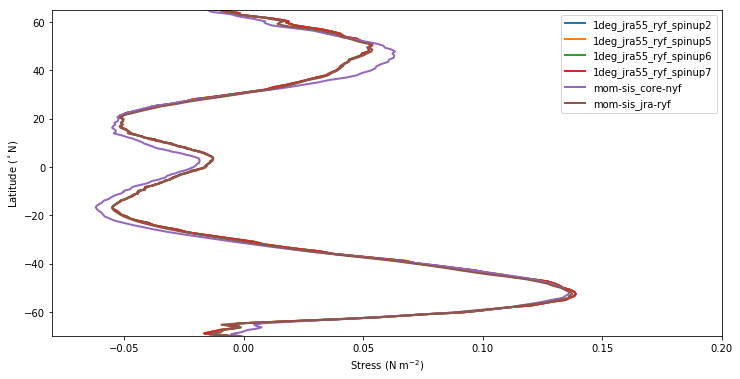

In [10]:
cc.plots.wind_stress(esub)

## Ocean Scalars
The following series of plots shows global timeseries of key metrics.

Calculating...done.


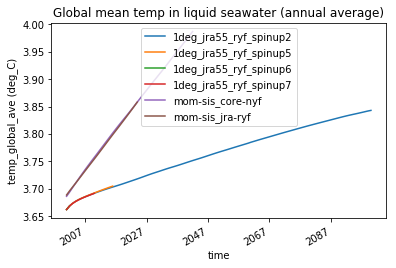

In [11]:
cc.plots.annual_scalar(esub, 'temp_global_ave')

Calculating...done.


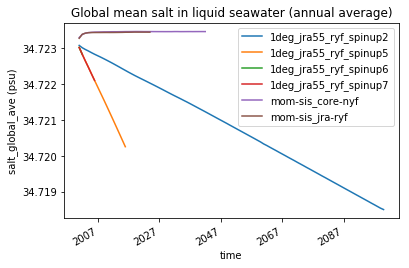

In [12]:
cc.plots.annual_scalar(esub, 'salt_global_ave')

Calculating...done.


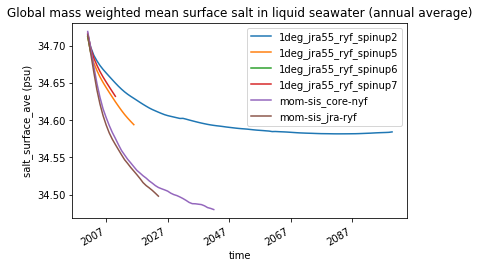

In [13]:
cc.plots.annual_scalar(esub, 'salt_surface_ave')

Calculating...done.


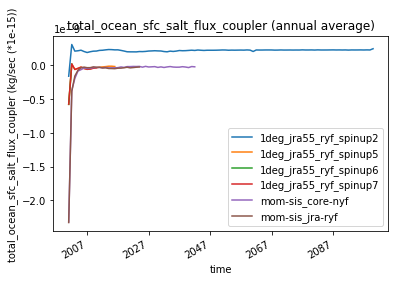

In [14]:
cc.plots.annual_scalar(esub, 'total_ocean_sfc_salt_flux_coupler')

In [15]:
variables = cc.netcdf_index.get_scalar_variables(configuration)

In [16]:
from ipywidgets import widgets, interact, interactive, fixed
interactive(cc.plots.annual_scalar,
            expts=fixed(esub),
            variable=widgets.Dropdown(options=variables, description='Scalar Variable:'))

A Jupyter Widget

# Re-doing Ocean Scalars
There are a few dodgy things going on withthe above functions. Just plotting these directly for  now ...

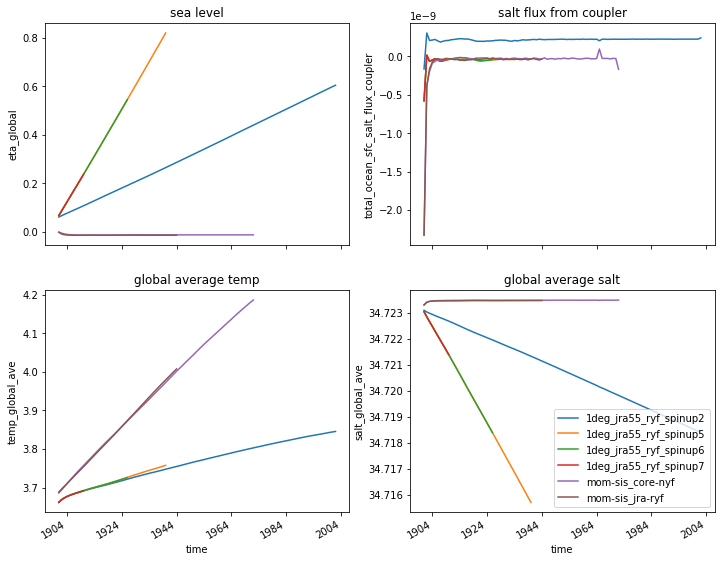

In [17]:
plt.figure(figsize=(12,10))
for e in esub:
    plt.subplot(221)
    eta = cc.get_nc_variable(e,'ocean_scalar.nc','eta_global',
                         time_units = 'days since 1900-01-01').resample('A',dim='time').plot(label=e)
    plt.title('sea level')
    
    plt.subplot(222)
    salt_flux = cc.get_nc_variable(e,'ocean_scalar.nc','total_ocean_sfc_salt_flux_coupler',
                         time_units = 'days since 1900-01-01').resample('A',dim='time').plot(label=e)
    plt.title('salt flux from coupler')
    
    plt.subplot(223)
    temp = cc.get_nc_variable(e,'ocean_scalar.nc','temp_global_ave',
                         time_units = 'days since 1900-01-01').resample('A',dim='time').plot(label=e)
    plt.title('global average temp')
    
    plt.subplot(224)
    salt = cc.get_nc_variable(e,'ocean_scalar.nc','salt_global_ave',
                         time_units = 'days since 1900-01-01').resample('A',dim='time').plot(label=e)
    plt.title('global average salt')

plt.legend()